In [1]:
%%capture
!pip install pandas
!pip install ruptures
!pip install numpy
!pip install matplotlib

!pip install saxpy
!pip install tsfresh
!pip install seaborn
!pip install sklearn
!pip3 install -U scikit-learn scipy matplotlib




# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.dates as mdates
import seaborn as sns

from matplotlib import pyplot as plt

# package for feature training

# sklearn packages
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans


from sklearn.impute import SimpleImputer

%matplotlib inline



In [2]:
file_path = './CC_LCL-FullData.csv'

df=pd.read_csv(file_path, nrows=10000)

df


,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0
...,...,...,...,...
9995,MAC000002,Std,2013-05-09 03:30:00.0000000,0.09
9996,MAC000002,Std,2013-05-09 04:00:00.0000000,0.114
9997,MAC000002,Std,2013-05-09 04:30:00.0000000,0.105
9998,MAC000002,Std,2013-05-09 05:00:00.0000000,0.099


In [3]:
df = df[df['KWH/hh (per half hour) '] != 0]
df['KWH/hh (per half hour) '].dropna()


df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

# Remove rows where "KWH/hh (per half hour)" is equal to or close to zero
df = df[df['KWH/hh (per half hour) '] != 0]
df

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
21,MAC000002,Std,2012-10-12 11:30:00.0000000,0.143
22,MAC000002,Std,2012-10-12 12:00:00.0000000,0.663
23,MAC000002,Std,2012-10-12 12:30:00.0000000,0.256
24,MAC000002,Std,2012-10-12 13:00:00.0000000,0.155
25,MAC000002,Std,2012-10-12 13:30:00.0000000,0.199
...,...,...,...,...
9995,MAC000002,Std,2013-05-09 03:30:00.0000000,0.090
9996,MAC000002,Std,2013-05-09 04:00:00.0000000,0.114
9997,MAC000002,Std,2013-05-09 04:30:00.0000000,0.105
9998,MAC000002,Std,2013-05-09 05:00:00.0000000,0.099


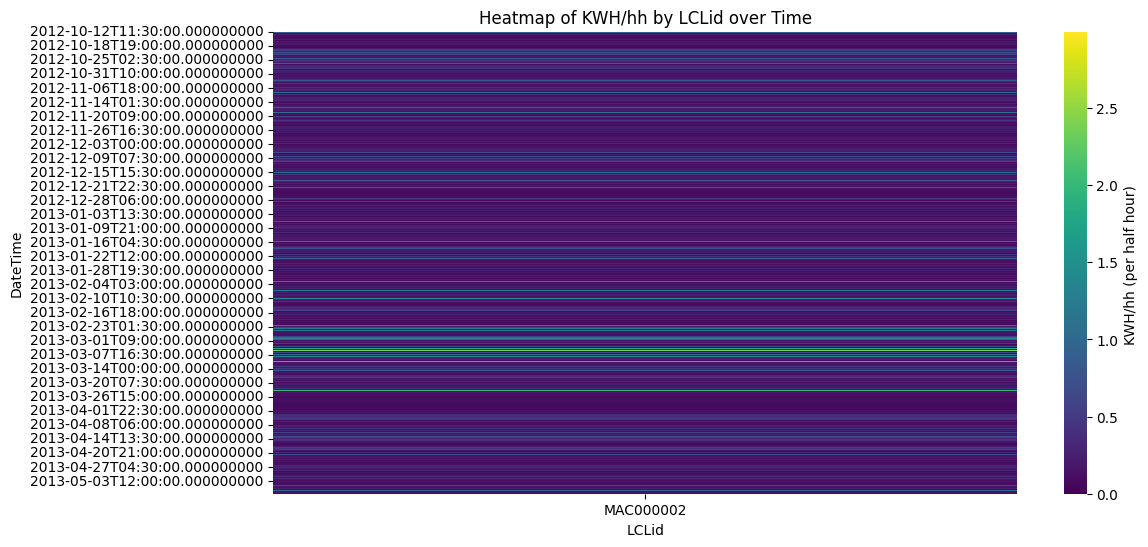

In [4]:
df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '], errors='coerce')

df['DateTime'] = pd.to_datetime(df['DateTime'])

heatmap_data = df.pivot_table(index='DateTime', columns='LCLid', values='KWH/hh (per half hour) ', aggfunc='sum')

heatmap_data = heatmap_data.dropna(axis=0, how='all')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'KWH/hh (per half hour) '})

plt.xlabel('LCLid')
plt.ylabel('DateTime')
plt.title('Heatmap of KWH/hh by LCLid over Time')

plt.show()

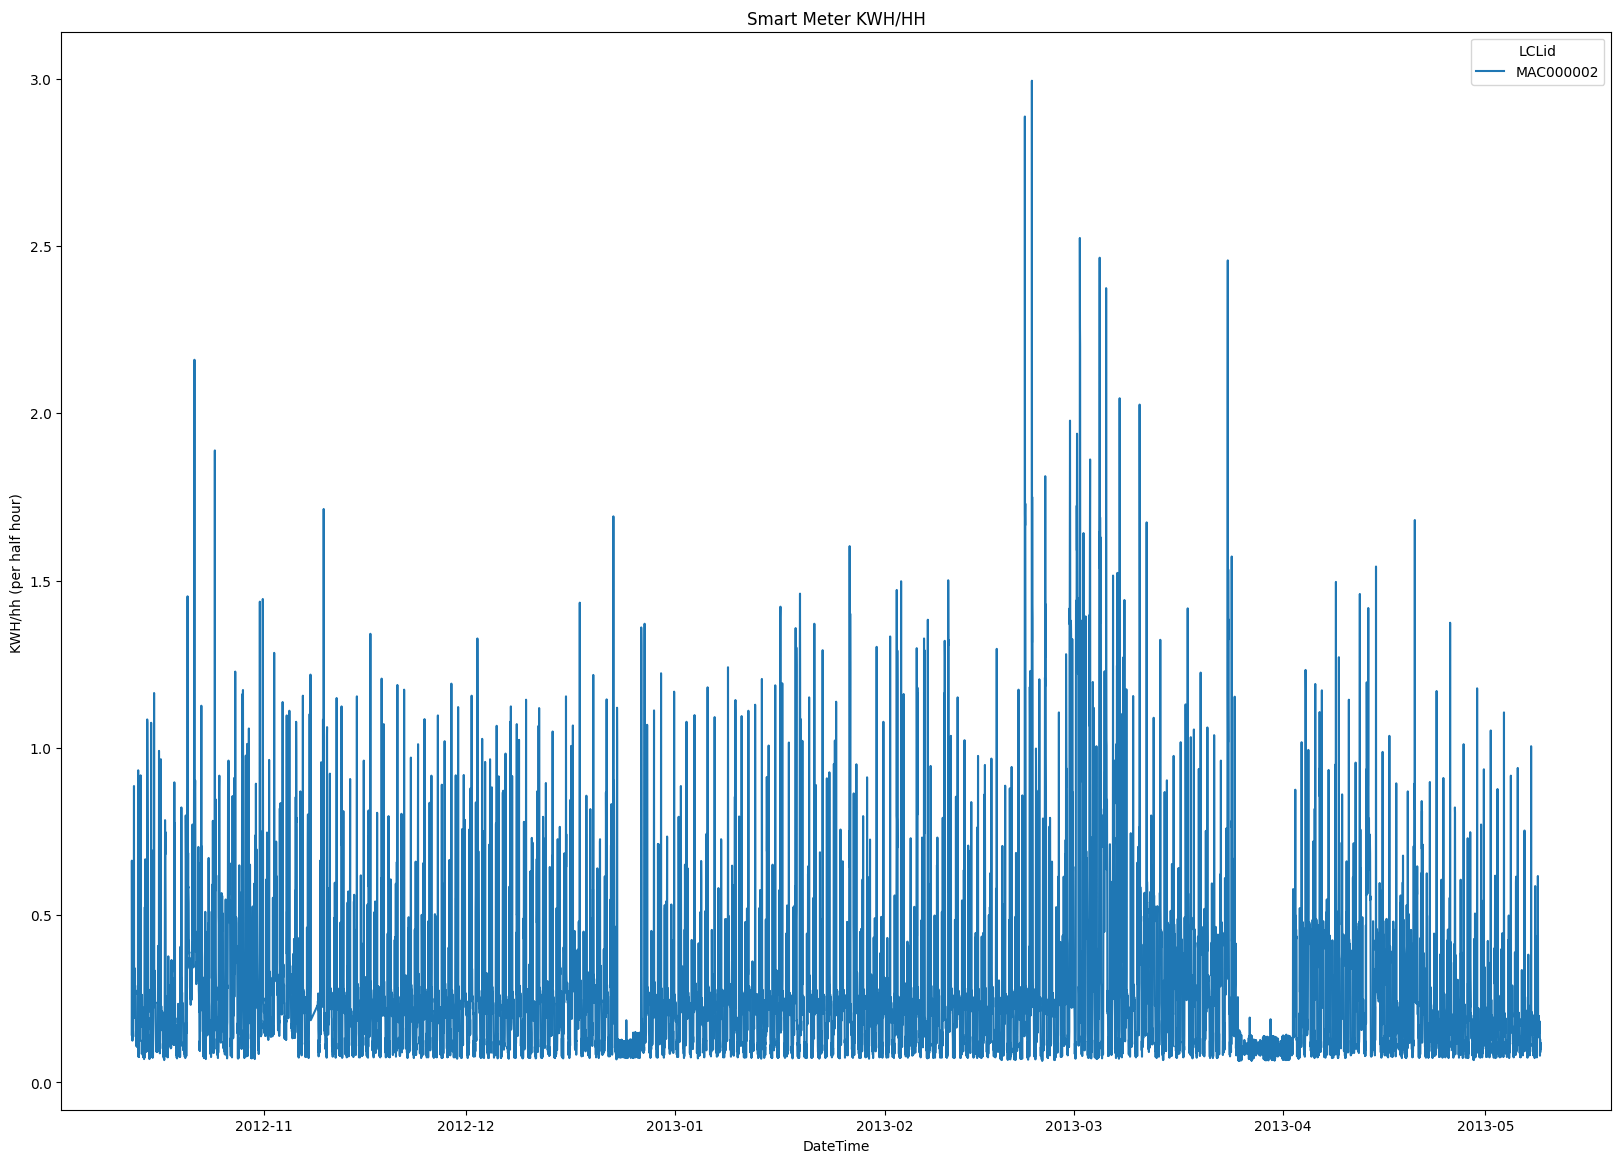

In [5]:
%matplotlib inline

df['DateTime'] = pd.to_datetime(df['DateTime'])

plt.figure(figsize=(20, 14))
sns.lineplot(x='DateTime', y='KWH/hh (per half hour) ', hue='LCLid', data=df)

plt.xlabel('DateTime')
plt.ylabel('KWH/hh (per half hour) ')
plt.title('Smart Meter KWH/HH')

plt.show()


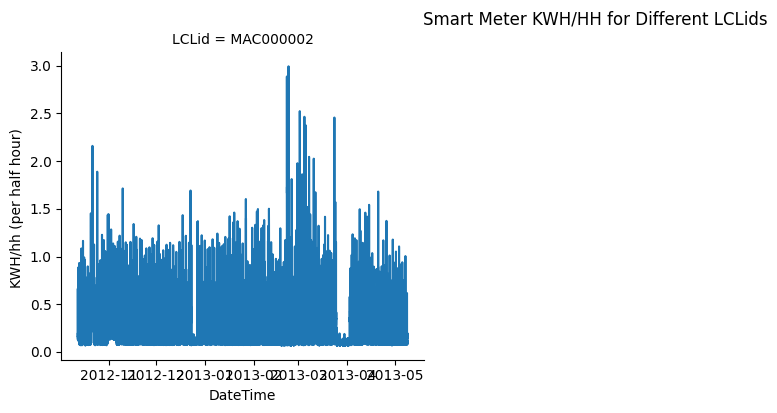

In [6]:
%matplotlib inline

# Assuming your data is stored in a DataFrame named df
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set up the FacetGrid
g = sns.FacetGrid(df, col="LCLid", col_wrap=3, height=4, sharey=False)
g.map(sns.lineplot, 'DateTime', 'KWH/hh (per half hour) ')

# Set common labels and title
g.set_axis_labels("DateTime", "KWH/hh (per half hour) ")
g.fig.suptitle('Smart Meter KWH/HH for Different LCLids', y=1.02)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


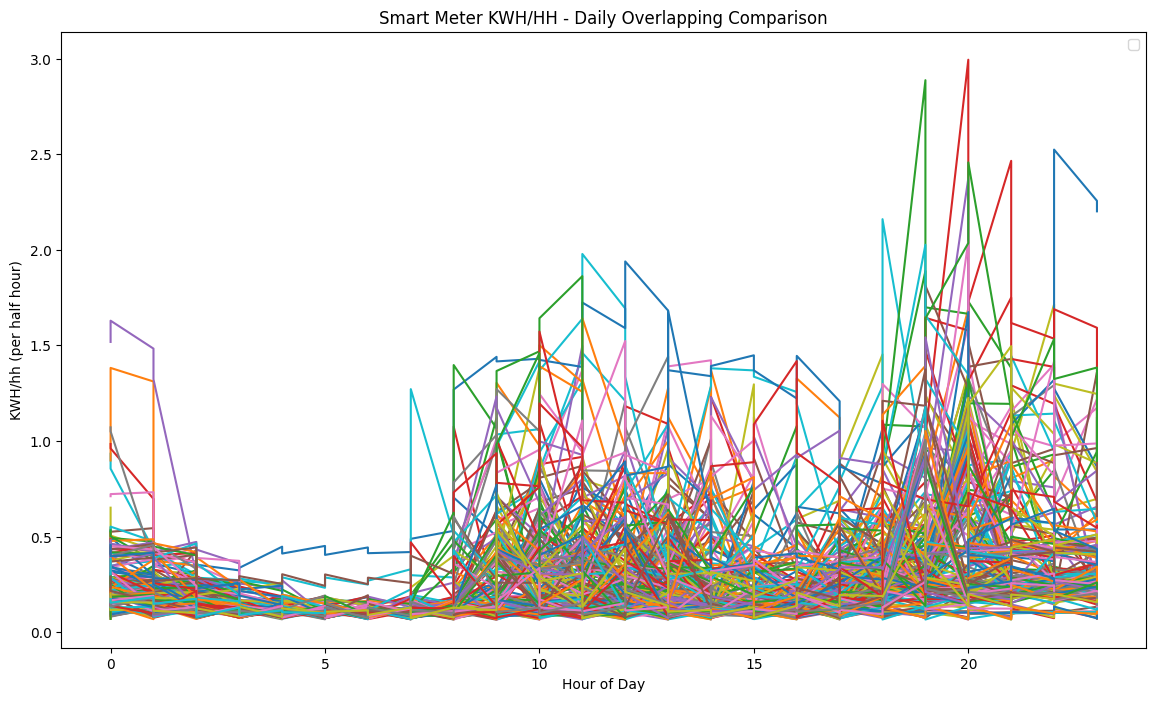

In [7]:

# Assuming your data is stored in a DataFrame named df
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract date from DateTime
df['Date'] = df['DateTime'].dt.date

# Set up the plot
plt.figure(figsize=(14, 8))

# Iterate over unique dates and plot each day's data on the same axis
for date in df['Date'].unique():
    date_data = df[df['Date'] == date]
    plt.plot(date_data['DateTime'].dt.hour, date_data['KWH/hh (per half hour) '])

# Set common labels and title
plt.xlabel('Hour of Day')
plt.ylabel('KWH/hh (per half hour)')
plt.title('Smart Meter KWH/HH - Daily Overlapping Comparison')
plt.legend()

plt.show()


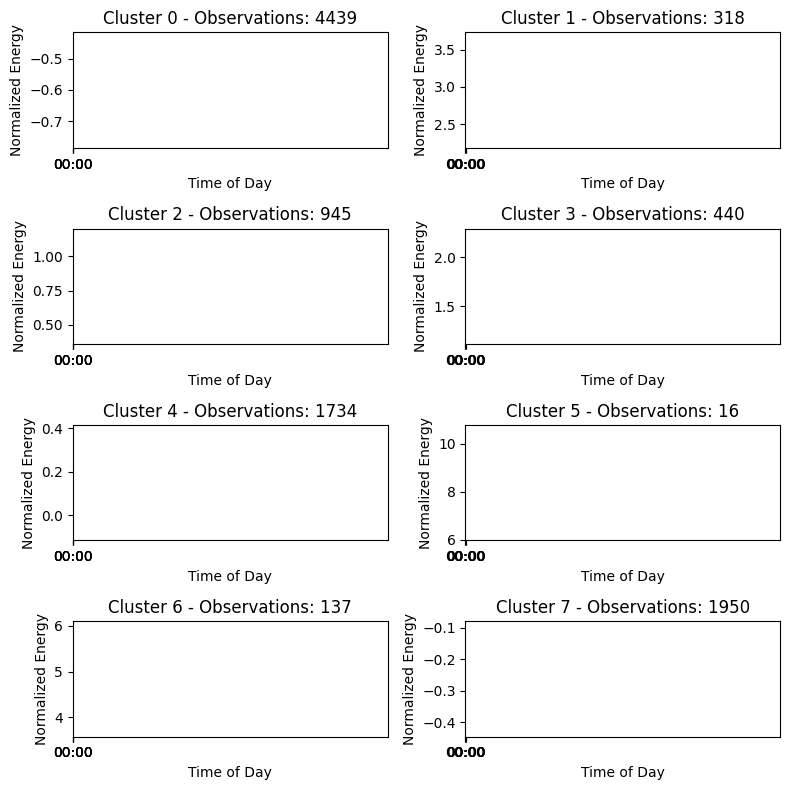

In [9]:
numeric_columns = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_columns]

# Use SimpleImputer to fill missing values with mean (you can choose other strategies)
imputer = SimpleImputer(strategy='mean')
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns, index=df_numeric.index)

# Extract the numeric values and scale/normalize the profiles
np_scaled = StandardScaler().fit_transform(df_numeric_imputed.values)

# define the number of clusters, fit the model to the scaled profiles and predict
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
np_preds = kmeans.fit_predict(np_scaled)

# create the figure
fig, ax = plt.subplots(int(math.ceil(n_clusters/2)), 2, figsize=(8, 8))
ax = ax.flatten()

# to visualize the clusters, loop over the clusters (i.e., unique labels of predictions)
for idx in np.unique(np_preds):

  # get the indices of the elements (rows) that belong to the same cluster
  indices = np.where(np_preds == idx)[0]

  # use the indices to get the relevant profiles
  np_profs = np_scaled[indices, :].T

  # plot all profiles of a cluster and their mean profile
  ax[idx].plot(np_profs, color='blue', alpha=0.2, linewidth=0.5)
  ax[idx].plot(np.mean(np_profs, axis=1), color='black', linewidth=2)

  # adjust additional formatting
  ax[idx].set_ylabel('Normalized Energy')
  ax[idx].set_xlabel('Time of Day')
  ax[idx].set_xticks(ax[idx].get_xticks())
  ax[idx].set_xticklabels(['{:02d}:{:02d}'.format(int(e/4), int(e%4)) for e in ax[idx].get_xticks()])
  ax[idx].set_title('Cluster {} - Observations: {}'.format(idx, len(indices)))
  ax[idx].set_xlim(0, 96)

# show
plt.tight_layout()
plt.show()

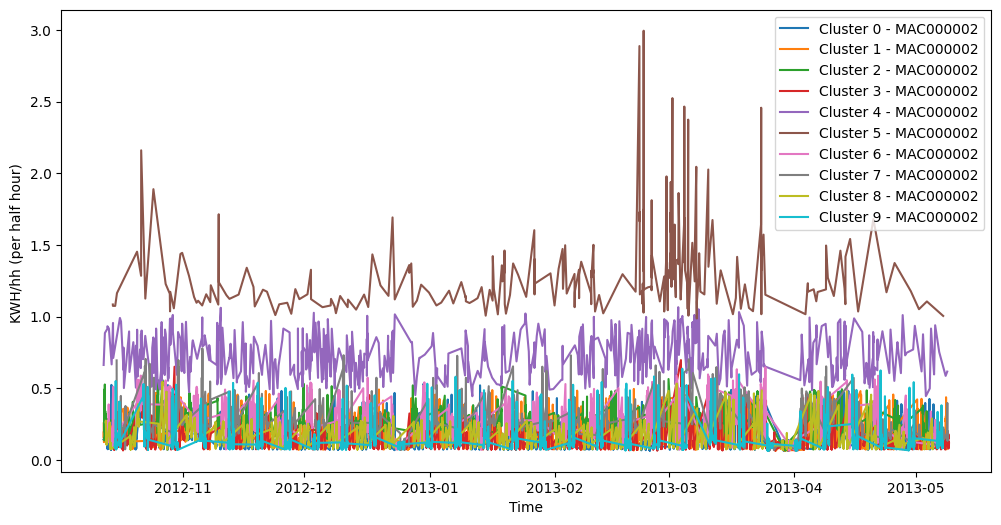

In [10]:

# Assuming your data is stored in a DataFrame named df
# Convert "DateTime" column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract time-related features
df['HourOfDay'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

# Select relevant features for clustering
features = ['HourOfDay', 'DayOfWeek', 'KWH/hh (per half hour) ']
df_features = df[features]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
df_features_imputed = pd.DataFrame(imputer.fit_transform(df_features), columns=features)

# Scale the features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features_imputed), columns=features)

# Apply K-Means clustering
n_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Plot the clustered data
plt.figure(figsize=(12, 6))
for cluster_id in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    for lclid, group in cluster_data.groupby('LCLid'):
        plt.plot(group['DateTime'], group['KWH/hh (per half hour) '], label=f'Cluster {cluster_id} - {lclid}')

plt.xlabel('Time')
plt.ylabel('KWH/hh (per half hour) ')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

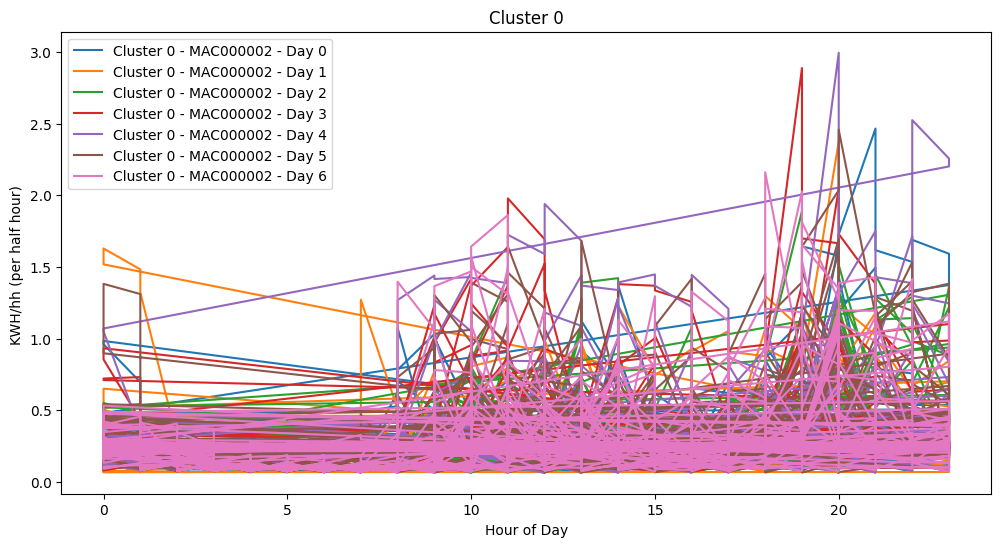

In [11]:
# Assuming your data is stored in a DataFrame named df
# Convert "DateTime" column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract time-related features
df['HourOfDay'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

# Select relevant features for clustering
features = ['HourOfDay', 'DayOfWeek', 'KWH/hh (per half hour) ']
df_features = df[features]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
df_features_imputed = pd.DataFrame(imputer.fit_transform(df_features), columns=features)

# Scale the features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features_imputed), columns=features)

# Apply K-Means clustering
n_clusters = 1  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Plot the clustered data
plt.figure(figsize=(12, 6))
for cluster_id in range(n_clusters):
    plt.figure(figsize=(12, 6))
    cluster_data = df[df['Cluster'] == cluster_id]
    for lclid, group in cluster_data.groupby(['LCLid', 'DayOfWeek']):
        plt.plot(group['HourOfDay'], group['KWH/hh (per half hour) '], label=f'Cluster {cluster_id} - {lclid[0]} - Day {lclid[1]}')

    plt.xlabel('Hour of Day')
    plt.ylabel('KWH/hh (per half hour) ')
    plt.title(f'Cluster {cluster_id}')
    plt.legend()
    plt.show()

In [12]:
# Assuming your data is stored in a DataFrame named df
# Convert "DateTime" column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract time-related features
df['HourOfDay'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

# Select relevant features for clustering
features = ['HourOfDay', 'DayOfWeek', 'KWH/hh (per half hour) ']
df_features = df[features]

# # Assuming 'LCLid' is your identifier column
# identifier_column = 'LCLid'

# # Specify columns for which missing values should be checked
# columns_to_check = df_features.columns[df_features.columns != identifier_column]

# Drop rows with missing values in the specified columns
df_cleaned = df_features.dropna(subset=columns_to_check)
# Scale the features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=features)

# Apply K-Means clustering
n_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
df_cleaned['Cluster'] = kmeans.fit_predict(df_scaled)

# Plot the clustered data
plt.figure(figsize=(12, 6))
for cluster_id in range(n_clusters):
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster_id]
    for lclid, group in cluster_data.groupby('LCLid'):
        plt.plot(group['DateTime'], group['KWH/hh (per half hour) '], label=f'Cluster {cluster_id} - {lclid}')


plt.xlabel('Time')
plt.ylabel('KWH/hh (per half hour) ')
plt.legend()
plt.show()

NameError: name 'columns_to_check' is not defined